In [1]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import SimpleITK as sitk

# 0. Dataset Preprocessing

In [2]:
# Make sure to add the following datasets to your kaggle notebook inputs:
# https://www.kaggle.com/datasets/kmader/headctreads
# https://www.kaggle.com/datasets/crawford/qureai-headct

base_dir = os.path.join("..", "input/datasets/crawford", "qureai-headct")
reads_dir = os.path.join("..", "input/datasets/kmader", "headctreads")

all_dicom_paths = glob(os.path.join(base_dir, "*", "*", "*", "*", "*"))
print(len(all_dicom_paths), "dicom files")
dicom_df = pd.DataFrame(dict(path=all_dicom_paths))
dicom_df["SliceNumber"] = dicom_df["path"].map(
    lambda x: int(os.path.splitext(x.split("/")[-1])[0][2:])
)
dicom_df["SeriesName"] = dicom_df["path"].map(lambda x: x.split("/")[-2])
dicom_df["StudyID"] = dicom_df["path"].map(lambda x: x.split("/")[-3])
dicom_df["PatientID"] = dicom_df["path"].map(lambda x: x.split("/")[-4].split(" ")[0])
dicom_df["PatSeries"] = dicom_df.apply(
    lambda x: "{PatientID}-{SeriesName}".format(**x), 1
)
dicom_df.sample(3)

165269 dicom files


,path,SliceNumber,SeriesName,StudyID,PatientID,PatSeries
43346,../input/datasets/crawford/qureai-headct/qct07...,13,CT POST CONTRAST,Unknown Study,CQ500CT243,CQ500CT243-CT POST CONTRAST
120214,../input/datasets/crawford/qureai-headct/qct15...,27,CT POST CONTRAST,Unknown Study,CQ500CT450,CQ500CT450-CT POST CONTRAST
82851,../input/datasets/crawford/qureai-headct/qct19...,158,CT PRE CONTRAST THIN,Unknown Study,CQ500CT95,CQ500CT95-CT PRE CONTRAST THIN


In [3]:
read_overview_df = pd.read_csv(os.path.join(reads_dir, "reads.csv"))
read_overview_df["PatientID"] = read_overview_df["name"].map(
    lambda x: x.replace("-", "")
)
display(read_overview_df.sample(2).T)

new_reads = []
for _, c_row in read_overview_df.iterrows():
    base_dict = OrderedDict(PatientID=c_row["PatientID"], Category=c_row["Category"])
    for reader in ["R1", "R2", "R3"]:
        c_dict = base_dict.copy()
        c_dict["Reader"] = reader
        for k, v in c_row.items():
            if (reader + ":") in k:
                c_dict[k.split(":")[-1]] = v
        new_reads += [c_dict]
new_reads_df = pd.DataFrame(new_reads)
new_reads_df.to_csv("formatted_reads.csv")
new_reads_df.sample(5)

,151,194
name,CQ500-CT-269,CQ500-CT-280
Category,B1,B1
R1:ICH,0,0
R1:IPH,0,0
R1:IVH,0,0
R1:SDH,0,0
R1:EDH,0,0
R1:SAH,0,0
R1:BleedLocation-Left,0,0
R1:BleedLocation-Right,0,0


,PatientID,Category,Reader,ICH,IPH,IVH,SDH,EDH,SAH,BleedLocation-Left,BleedLocation-Right,ChronicBleed,Fracture,CalvarialFracture,OtherFracture,MassEffect,MidlineShift
744,CQ500CT409,B1,R1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1374,CQ500CT214,B2,R1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
504,CQ500CT450,B1,R1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
689,CQ500CT437,B1,R3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
619,CQ500CT83,B1,R2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
maj_reads_df = (
    new_reads_df.drop(columns=["Reader"])
    .groupby(["PatientID", "Category"])
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

read_dicom_df = pd.merge(maj_reads_df, dicom_df, on="PatientID")
print(read_dicom_df.shape[0], "total weakly-labeled slices")
read_dicom_df.sample(3)

165269 total weakly-labeled slices


,PatientID,Category,ICH,IPH,IVH,SDH,EDH,SAH,BleedLocation-Left,BleedLocation-Right,...,Fracture,CalvarialFracture,OtherFracture,MassEffect,MidlineShift,path,SliceNumber,SeriesName,StudyID,PatSeries
61896,CQ500CT257,B2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,../input/datasets/crawford/qureai-headct/qct07...,247,CT 0.625mm,Unknown Study,CQ500CT257-CT 0.625mm
164898,CQ500CT98,B1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,../input/datasets/crawford/qureai-headct/qct19...,245,CT PRE CONTRAST THIN,Unknown Study,CQ500CT98-CT PRE CONTRAST THIN
148632,CQ500CT57,B2,1,1,0,0,0,0,1,1,...,0,0,0,0,0,../input/datasets/crawford/qureai-headct/qct17...,32,CT 0.625mm,Unknown Study,CQ500CT57-CT 0.625mm


In [5]:
meta_df = read_dicom_df[
    [
        "PatientID",
        "ICH",
        "Fracture",
        "MassEffect",
        "MidlineShift",
        "path",
        "SliceNumber",
        "SeriesName",
    ]
]
meta_df[["ICH", "Fracture", "MassEffect", "MidlineShift"]] = meta_df[
    ["ICH", "Fracture", "MassEffect", "MidlineShift"]
].astype(bool)

meta_df

/tmp/ipykernel_24/3413344970.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df[["ICH", "Fracture", "MassEffect", "MidlineShift"]] = meta_df[


,PatientID,ICH,Fracture,MassEffect,MidlineShift,path,SliceNumber,SeriesName
0,CQ500CT0,False,False,False,False,../input/datasets/crawford/qureai-headct/qct01...,110,CT PLAIN THIN
1,CQ500CT0,False,False,False,False,../input/datasets/crawford/qureai-headct/qct01...,170,CT PLAIN THIN
2,CQ500CT0,False,False,False,False,../input/datasets/crawford/qureai-headct/qct01...,113,CT PLAIN THIN
3,CQ500CT0,False,False,False,False,../input/datasets/crawford/qureai-headct/qct01...,67,CT PLAIN THIN
4,CQ500CT0,False,False,False,False,../input/datasets/crawford/qureai-headct/qct01...,28,CT PLAIN THIN
...,...,...,...,...,...,...,...,...
165264,CQ500CT99,False,False,False,False,../input/datasets/crawford/qureai-headct/qct19...,30,CT PRE CONTRAST 5MM STD
165265,CQ500CT99,False,False,False,False,../input/datasets/crawford/qureai-headct/qct19...,29,CT PRE CONTRAST 5MM STD
165266,CQ500CT99,False,False,False,False,../input/datasets/crawford/qureai-headct/qct19...,2,CT PRE CONTRAST 5MM STD
165267,CQ500CT99,False,False,False,False,../input/datasets/crawford/qureai-headct/qct19...,0,CT PRE CONTRAST 5MM STD


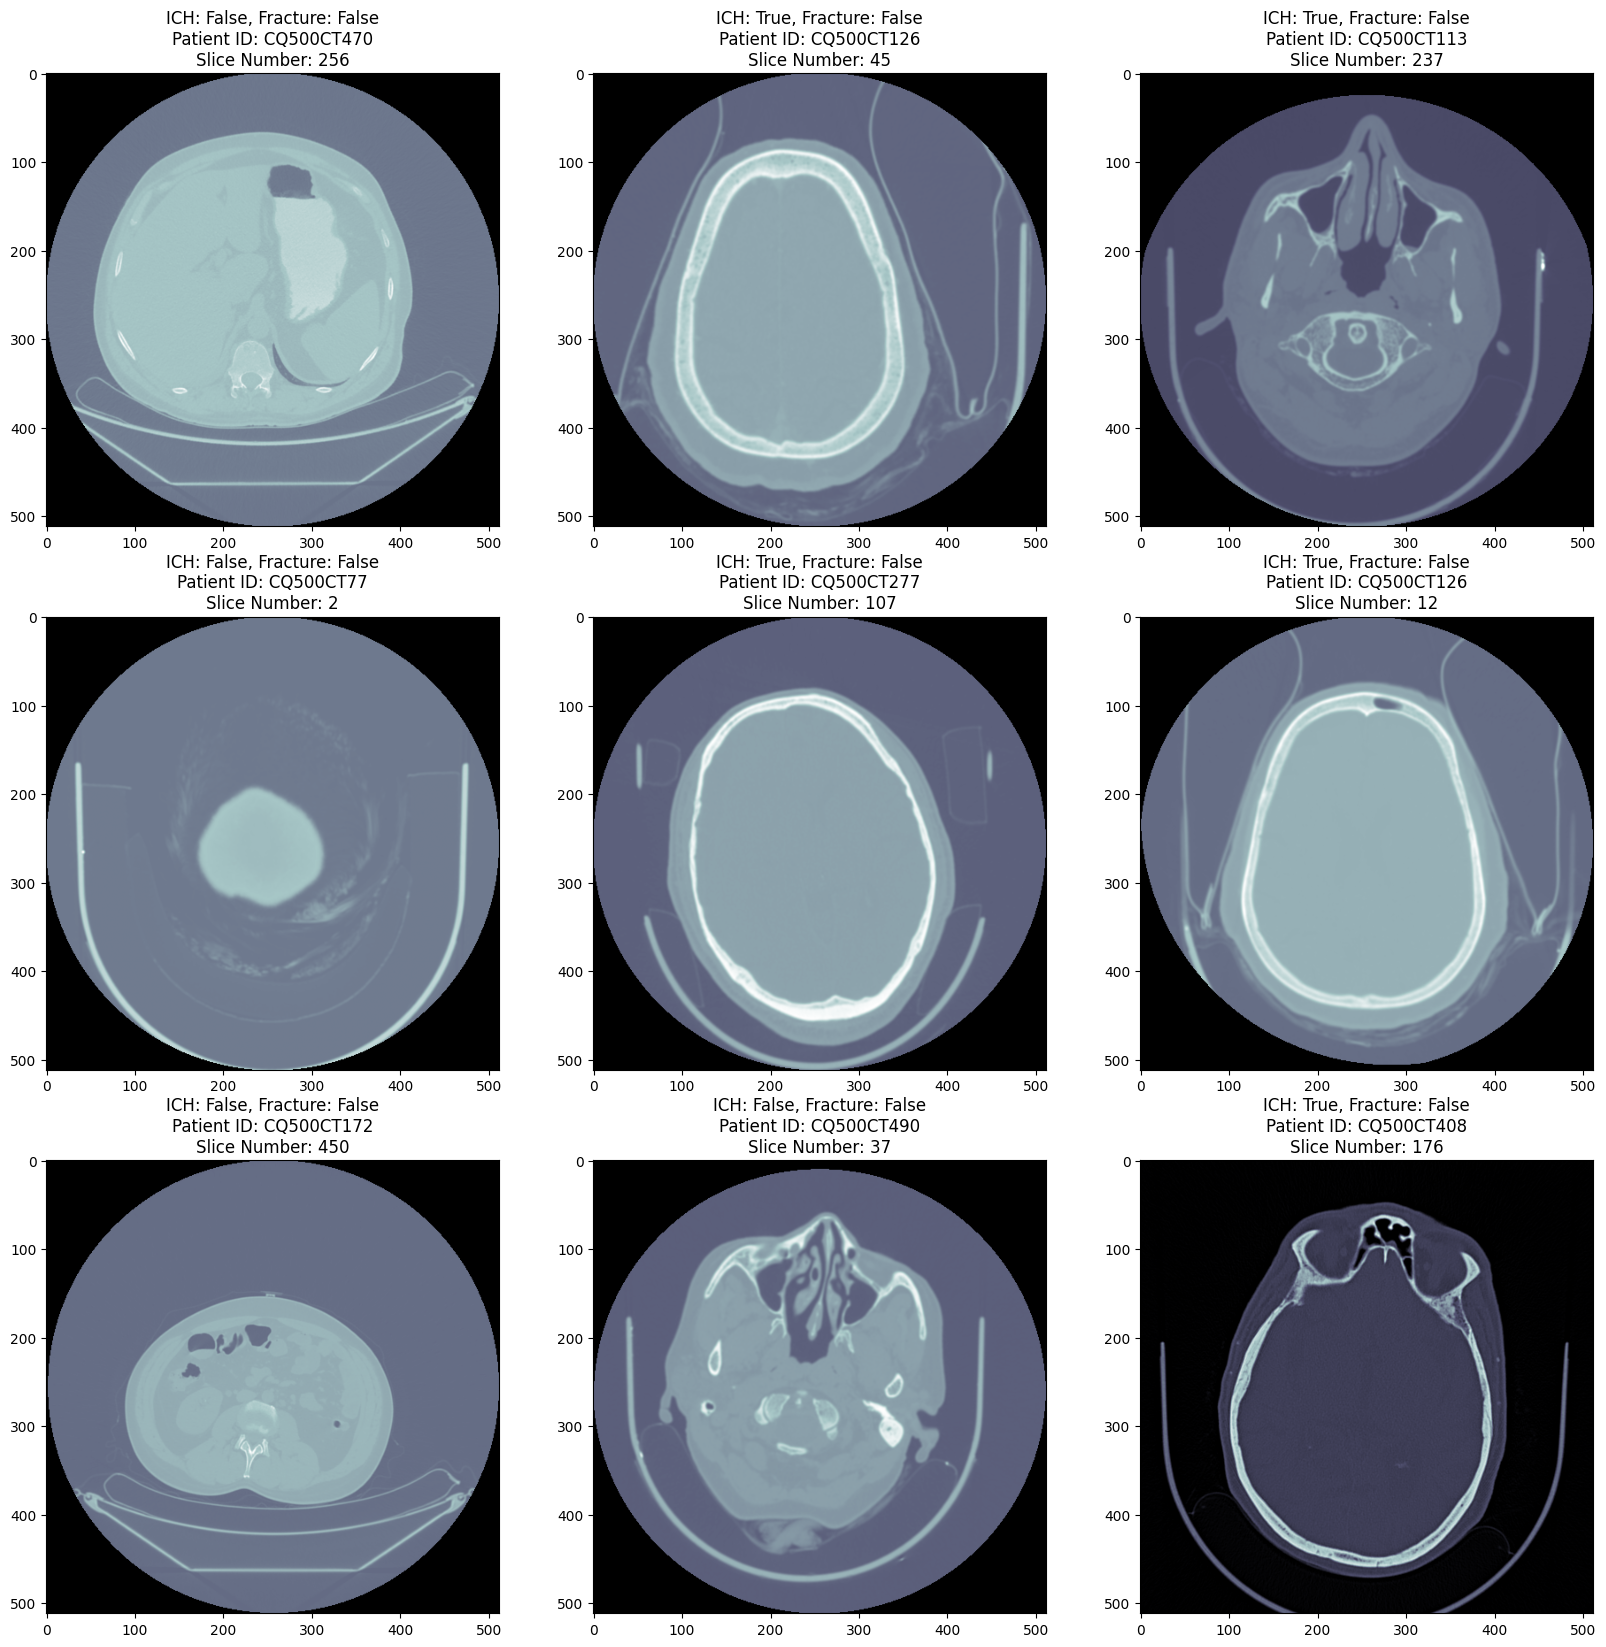

In [6]:
fig, m_axs = plt.subplots(3, 3, figsize=(20, 20))
for c_ax, (_, c_row) in zip(m_axs.flatten(), meta_df.sample(9).iterrows()):
    c_img = sitk.ReadImage(c_row["path"])
    # shape of c_slice: (512, 512)
    c_slice = sitk.GetArrayFromImage(c_img)[0]
    c_ax.imshow(c_slice, cmap="bone")
    c_ax.set_title(
        "ICH: {ICH}, Fracture: {Fracture}\nPatient ID: {PatientID}\nSlice Number: {SliceNumber}".format(
            **c_row
        )
    )

In [7]:
def reduce_patients(meta_df, class_name, n_keep, random_state=42):

    pathology_cols = ["ICH", "Fracture", "MassEffect", "MidlineShift"]

    patient_pathology = meta_df.groupby("PatientID")[pathology_cols].any()

    if class_name == "Normal":
        class_patients = patient_pathology[~patient_pathology.any(axis=1)].index

    elif class_name in pathology_cols:
        other_cols = [c for c in pathology_cols if c != class_name]

        class_patients = patient_pathology[
            (patient_pathology[class_name] == True)
            & (~patient_pathology[other_cols].any(axis=1))
        ].index

    else:
        raise ValueError(
            "class_name must be one of: Normal, ICH, Fracture, MassEffect, MidlineShift"
        )

    original_count = len(class_patients)

    keep_patients = pd.Series(class_patients).sample(
        min(n_keep, original_count), random_state=random_state
    )

    new_meta_df = meta_df[
        meta_df["PatientID"].isin(keep_patients)
        | ~meta_df["PatientID"].isin(class_patients)
    ]

    print(f"{class_name}-only patients: {original_count} → {len(keep_patients)} kept")

    return new_meta_df


prev_counts = meta_df.value_counts(
    ["ICH", "Fracture", "MassEffect", "MidlineShift"]
).reset_index(name="count")

n_keep = 70
meta_df = reduce_patients(meta_df, "Normal", n_keep)
meta_df = reduce_patients(meta_df, "ICH", n_keep)

meta_df.to_csv("/kaggle/working/meta_df.csv", index=False)
print("\nmeta_df saved to a csv file!\n")

new_counts = meta_df.value_counts(
    ["ICH", "Fracture", "MassEffect", "MidlineShift"]
).reset_index(name="count")

print("\nprevious counts:")
display(prev_counts)
print("\nnew counts:")
display(new_counts)

Normal-only patients: 263 → 70 kept
ICH-only patients: 70 → 70 kept

meta_df saved to a csv file!


previous counts:


,ICH,Fracture,MassEffect,MidlineShift,count
0,False,False,False,False,91212
1,True,False,False,False,26800
2,True,False,True,True,17394
3,True,False,True,False,14923
4,True,True,True,False,4147
5,True,True,False,False,3466
6,False,True,False,False,3390
7,True,True,True,True,3033
8,False,False,True,False,538
9,False,False,True,True,366



new counts:


,ICH,Fracture,MassEffect,MidlineShift,count
0,True,False,False,False,26800
1,False,False,False,False,21235
2,True,False,True,True,17394
3,True,False,True,False,14923
4,True,True,True,False,4147
5,True,True,False,False,3466
6,False,True,False,False,3390
7,True,True,True,True,3033
8,False,False,True,False,538
9,False,False,True,True,366


# 1. Feature Extraction

In [8]:
!mkdir -p ./IABI-Final-Project
!git -C IABI-Final-Project pull || git clone https://github.com/MobinaPoulaei/IABI-Final-Project
!mv IABI-Final-Project/ICMIL ./
!rm -rf IABI-Final-Project/

fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
Cloning into 'IABI-Final-Project'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 121 (delta 24), reused 117 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 1.28 MiB | 5.30 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [9]:
import os
import numpy as np
import torch
import torchvision.transforms as T
import SimpleITK as sitk
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

import sys

sys.path.append("/kaggle/working")
from ICMIL.utils.feature_extraction import resnet50_baseline


####====================================== USER CONFIG
BATCH_SIZE = 32
save_folder_dir = "/kaggle/working/CQ500_ICH_VS_NORMAL"

pathology_col = "ICH"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

random_state = 42
####======================================


# -------------------------------
# Create patient-level labels
# -------------------------------

pathology_cols = ["ICH", "Fracture", "MassEffect", "MidlineShift"]
patient_pathology = meta_df.groupby("PatientID")[pathology_cols].any()

ICH_only = (patient_pathology["ICH"] == True) & (
    ~patient_pathology[["Fracture", "MassEffect", "MidlineShift"]].any(axis=1)
)

Normal_only = ~patient_pathology.any(axis=1)
patient_labels = pd.DataFrame(index=patient_pathology.index)
patient_labels["class"] = None

patient_labels.loc[ICH_only, "class"] = "ICH"
patient_labels.loc[Normal_only, "class"] = "Normal"

# remove other mixed-pathology patients
patient_labels = patient_labels.dropna()

print(patient_labels["class"].value_counts())

# -------------------------------
# Train / Val / Test split
# -------------------------------

patients = patient_labels.index.values
labels = patient_labels["class"].values

train_patients, temp_patients, train_labels, temp_labels = train_test_split(
    patients,
    labels,
    test_size=(1 - train_ratio),
    stratify=labels,
    random_state=random_state,
)

val_patients, test_patients, val_labels, test_labels = train_test_split(
    temp_patients,
    temp_labels,
    test_size=test_ratio / (test_ratio + val_ratio),
    stratify=temp_labels,
    random_state=random_state,
)

splits = {"train": train_patients, "val": val_patients, "test": test_patients}

print("\nSplit sizes:")
for k, v in splits.items():
    print(k, len(v))


# -------------------------------
# Image transform
# -------------------------------

transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
    ]
)


# -------------------------------
# Model
# -------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50_baseline(True).to(device)
model.eval()

print("Device:", device)


# -------------------------------
# Create patient → slices mapping
# -------------------------------

patient_slices = {}

for _, row in meta_df.iterrows():
    pid = row.PatientID
    if pid not in patient_labels.index:
        continue

    patient_slices.setdefault(pid, []).append((row.path, row.SliceNumber))

# sort slices
for pid in patient_slices:
    patient_slices[pid].sort(key=lambda x: x[1])

# -------------------------------
# Feature extraction
# -------------------------------


def load_slice(path):
    img = sitk.ReadImage(path)
    arr = sitk.GetArrayFromImage(img)[0]

    # normalize to 0-255
    arr = arr.astype(np.float32)

    arr -= arr.min()
    arr /= arr.max() + 1e-8
    arr *= 255.0

    arr = arr.astype(np.uint8)

    # convert to RGB
    pil_img = Image.fromarray(arr).convert("RGB")

    return pil_img


for split_name, split_patients in splits.items():
    print("\nProcessing", split_name)

    for pid in tqdm(split_patients):
        cls = patient_labels.loc[pid, "class"]
        save_dir = os.path.join(save_folder_dir, split_name, cls)
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{pid}_resnet1024_feats.npy")

        if os.path.exists(save_path):
            continue

        slices = patient_slices[pid]
        feats = []

        for i in range(0, len(slices), BATCH_SIZE):
            batch = slices[i : i + BATCH_SIZE]
            input_tensor = torch.empty((0, 3, 224, 224), device=device)

            for path, _ in batch:
                img = load_slice(path)
                input_tensor = torch.cat(
                    [input_tensor, transform(img).unsqueeze(0).to(device)], dim=0
                )

            with torch.no_grad():
                feat = model(input_tensor)

            feats.extend(feat.cpu().numpy())

        feats = np.array(feats)
        np.save(save_path, feats)

print("\nFeature extraction completed!")

class
ICH       70
Normal    70
Name: count, dtype: int64

Split sizes:
train 97
val 21
test 22
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 310MB/s]


Device: cuda

Processing train


100%|██████████| 97/97 [16:42<00:00, 10.34s/it]



Processing val


100%|██████████| 21/21 [04:37<00:00, 13.22s/it]



Processing test


100%|██████████| 22/22 [04:39<00:00, 12.72s/it]


Feature extraction completed!


# 2. Train Classifier

In [10]:
!python3 ICMIL/02_train_classifier_cq500.py \
    --data_path "/kaggle/working/CQ500_ICH_VS_NORMAL" \
    --EPOCH 200 \
    --lr 1e-4 \
    --num_cls 2


Loading train set: 97 patients

Loading val set: 21 patients

Loading test set: 22 patients

=== Initial Test (before training) ===
y_score shape: (22, 2)
y_true shape: (22,)
validation results
auc: 0.7769, acc: 0.5000, f1: 0.3333

=== Epoch 1/200 - Learning rate: 0.0001 ===

[EPOCH 1 Summary] avg_loss_1:0.7694; avg_loss1:0.7093

=== Validating on Val Set ===
y_score shape: (21, 2)
y_true shape: (21,)
validation results
auc: 0.3364, acc: 0.4762, f1: 0.3226

*** New best AUC: 0.3364 at epoch 1. Testing on Test Set... ***
y_score shape: (22, 2)
y_true shape: (22,)
validation results
auc: 0.4050, acc: 0.5000, f1: 0.3333
Saving best model to model_best_cq500.pth

=== Epoch 2/200 - Learning rate: 0.0001 ===

[EPOCH 2 Summary] avg_loss_1:0.7295; avg_loss1:0.6966

=== Validating on Val Set ===
y_score shape: (21, 2)
y_true shape: (21,)
validation results
auc: 0.3818, acc: 0.4762, f1: 0.3226

*** New best AUC: 0.3818 at epoch 2. Testing on Test Set... ***
y_score shape: (22, 2)
y_true shape: 

# 3. Train Embedder

In [11]:
!python3 ICMIL/03_train_embedder_cq500.py \
    --data_root "/kaggle/working/CQ500_ICH_VS_NORMAL" \
    --meta_df_path "/kaggle/working/meta_df.csv" \
    --checkpoint_path "model_best_cq500.pth" \
    --num_cls 2 \
    --EPOCH 2 \
    --lr 1e-4 \
    --batch_size 16

Loading Teacher Models...
Teacher models loaded and frozen.
Initializing Student Models...
Student models initialized.
train: 33087 slices
val: 7327 slices
test: 7621 slices
Train samples: 33087
Val samples: 7327
Test samples: 7621

Starting Distillation Training...

Epoch [1/2] - Learning Rate: 0.0001
  [Epoch 1, Iter 0/2068] Loss: 0.9473 | L_c: 0.9472 | L_w1: 0.0002 | L_w2: 0.0000
  [Epoch 1, Iter 200/2068] Loss: 0.0034 | L_c: 0.0033 | L_w1: 0.0001 | L_w2: 0.0000
  [Epoch 1, Iter 400/2068] Loss: 0.0036 | L_c: 0.0036 | L_w1: 0.0001 | L_w2: 0.0000
  [Epoch 1, Iter 600/2068] Loss: 0.0043 | L_c: 0.0043 | L_w1: 0.0000 | L_w2: 0.0000
  [Epoch 1, Iter 800/2068] Loss: 0.0022 | L_c: 0.0021 | L_w1: 0.0001 | L_w2: 0.0000
  [Epoch 1, Iter 1000/2068] Loss: 0.0035 | L_c: 0.0035 | L_w1: 0.0001 | L_w2: 0.0000
  [Epoch 1, Iter 1200/2068] Loss: 0.0018 | L_c: 0.0018 | L_w1: 0.0000 | L_w2: 0.0000
  [Epoch 1, Iter 1400/2068] Loss: 0.0017 | L_c: 0.0017 | L_w1: 0.0001 | L_w2: 0.0000
  [Epoch 1, Iter 1600/2